# Joy Division Style Topography of England Animation

Here I make an animated topographic map of the UK in the style of the album artwork for Joy Division's Unknown Pleasures (Peter Saville's drawing of a comparative path demonstration of frequency from a signal of a pulsar).

For topography data I use DEFRA's downloadable json files; for plotting I will use Matplotlib.

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import pandas as pd
import urllib.request
import zipfile

# download and unzip the data
if 'data' not in os.listdir():
    url = 'https://environment.data.gov.uk/UserDownloads/interactive/6681b963ac2e4083aae4d2c5cb344c7492964/EA_LIDARGroundTruthSurveys_GeoJSON_Full.zip' 
    urllib.request.urlretrieve(url, 'LIDAR.json.zip')
    with zipfile.ZipFile('LIDAR.json.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

# read the JSON file into dictionary obj
with open('data/LIDAR_Ground_Truth_Surveys.json', 'r') as file:
    data = file.read()
obj = json.loads(data)

In [7]:
# extract the coordinates and altitude for each of the points listed in the dictionary
df = pd.DataFrame.from_dict({x['id']: x['geometry']['coordinates'] for x in obj['features']},
                            orient='index',
                            columns=['X', 'Y', 'Z'])

# rescale to get standard format lat, lon coordinate values
df[['X', 'Y']] *= 0.0001

In [11]:
# organise into a grid of Zs by downsampling and pivoting
grid = df.round(0)\
         .groupby(['X', 'Y'], group_keys=False).apply(max)\
         .pivot('Y', 'X', 'Z')\
         .interpolate(limit=2)\
         .add(100).fillna(0)\
         .to_numpy()[::-1,...] 

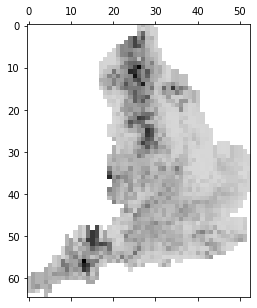

In [12]:
# initial plot to check 
plt.matshow(grid, cmap='gray_r')

## Style 1

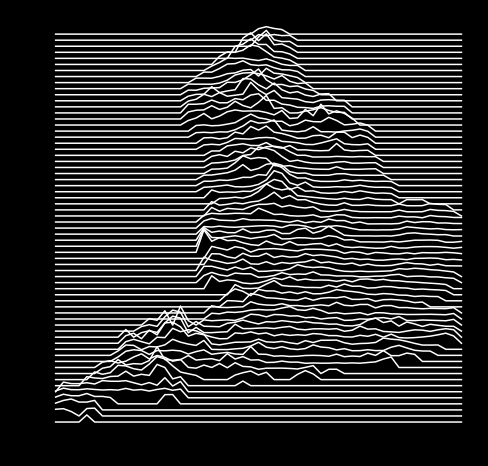

In [14]:
# first let's try a static plot 

fig = plt.figure(figsize=(8, 8), facecolor='black')
ax = plt.subplot(111, frameon=False)

# plot each grid row as a line offset by the row index (and scaled)
_ = [ax.plot(row/150 - y, color='w') for y, row in enumerate(grid)]

MovieWriter ffmpeg unavailable; using Pillow instead.


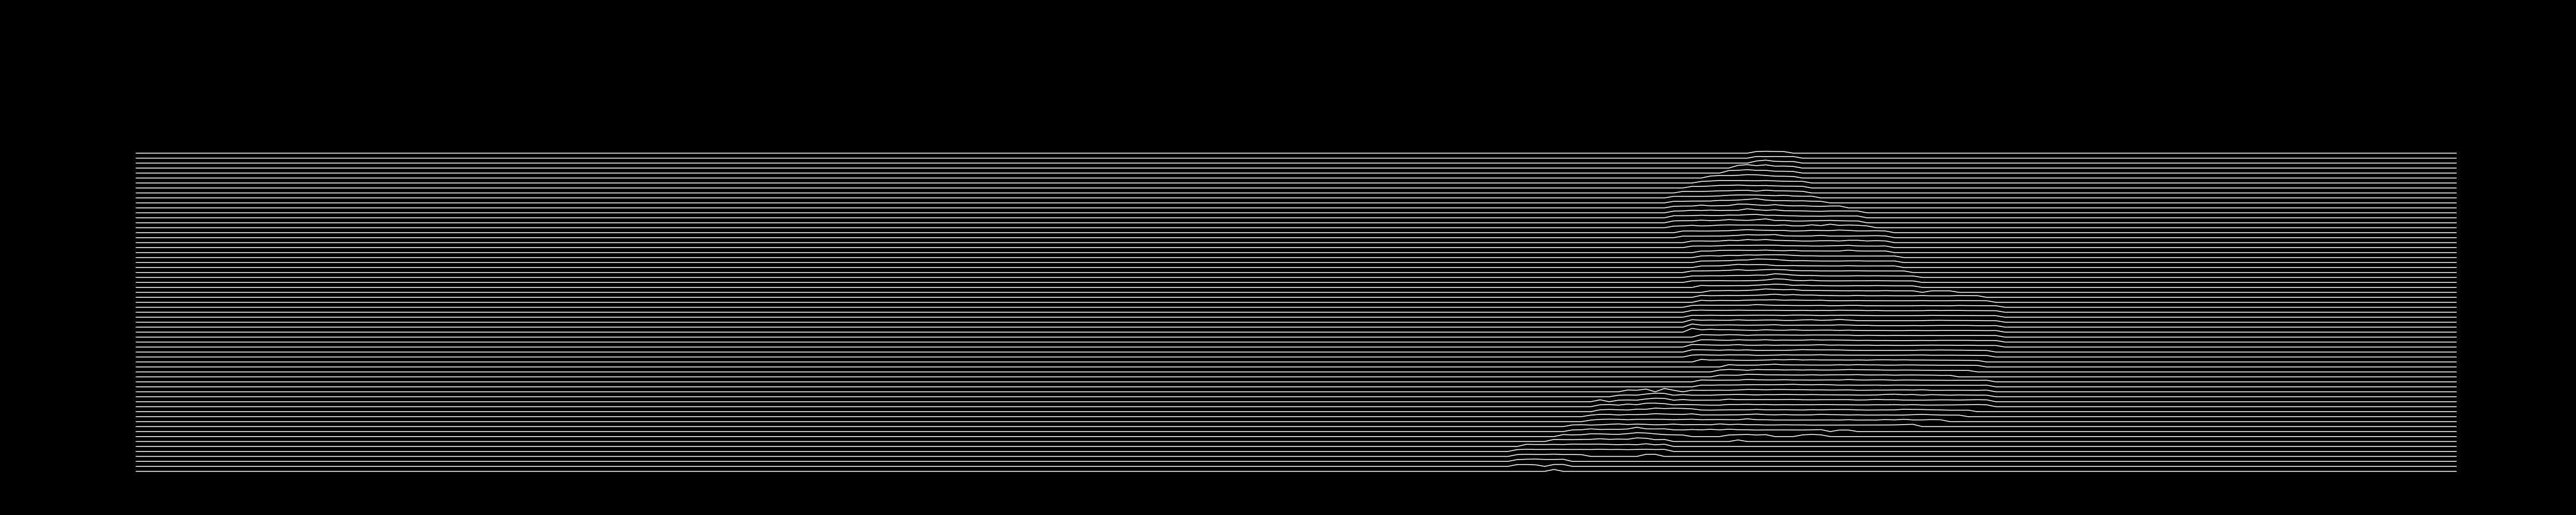

In [93]:
# now let's try an animation

fig = plt.figure(figsize=(80, 16), facecolor='black')
ax = plt.subplot(111, frameon=False)

# pad the grad horizontally with zeros so it's not bordered so tightly
grid_padded = np.hstack([np.zeros([65, 150]), grid, np.zeros([65, 50])])

# we need a collection of frames to iterate through, use the scale factors
frames = np.linspace(1000, 30, 100)
frames = np.append(frames, frames.copy()[::-1])

# define the function that produces lines for each frame
def get_lines(frame):
    # clear the axis and set a fixed y_lim
    ax.clear()
    ax.set_ylim(-70, 30)
    return [ax.plot(row/frame - y, color='w') for y, row in enumerate(grid_padded)]

# create the animation, setting the interval to an appropriate length
ani = animation.FuncAnimation(fig, get_lines, frames=frames, interval=30)
ani.save('joy_division_england_topography.gif')

## Style 2

In [41]:
# we want to increase the constant shift to 300 so we must redefine grid
grid = df.round(0)\
         .groupby(['X', 'Y'], group_keys=False).apply(max)\
         .pivot('Y', 'X', 'Z')\
         .interpolate(limit=2)\
         .add(300).fillna(0)\
         .to_numpy()[::-1,...] 

# also define a base random noise grid
grid_random = np.random.uniform(high=.5, size=[65, 150+grid.shape[1]+50])

# and pad grid so its size matches this random noise grid
grid_overlay = np.hstack([np.zeros([65, 150]), grid, np.zeros([65, 50])])

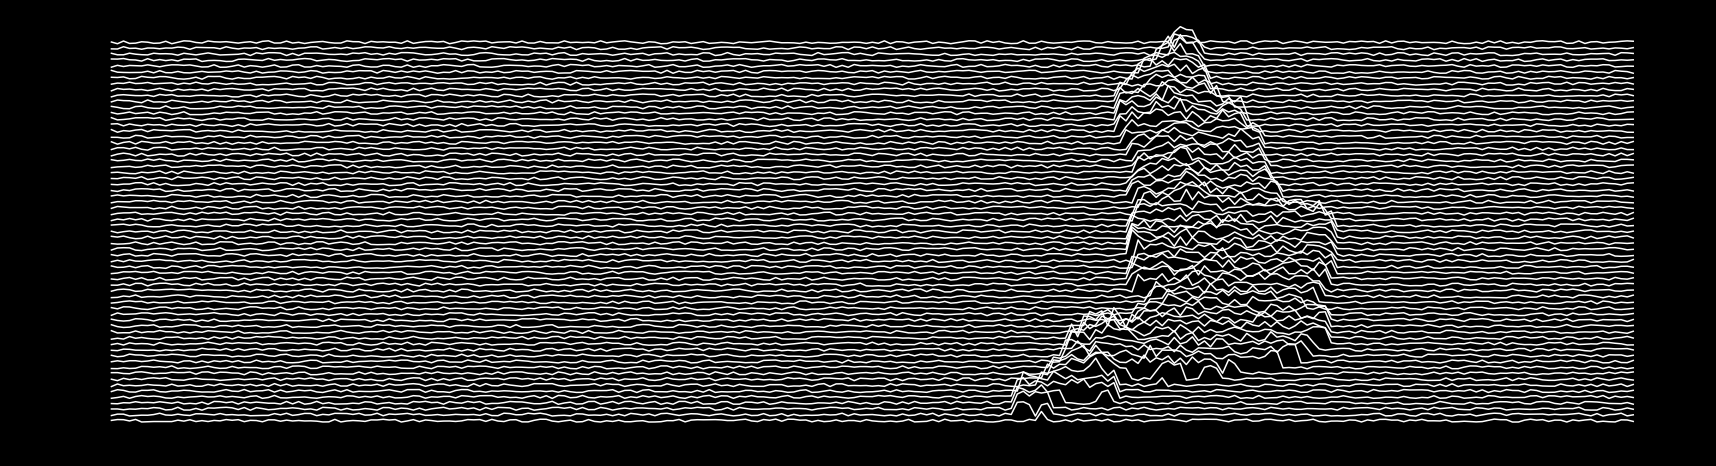

In [94]:
fig = plt.figure(figsize=(30, 8), facecolor='black')
ax = plt.subplot(111, frameon=False)

# let's overlay the England topography and also scale up the noise over the England shape
grid_i = grid_random + np.multiply(grid_random.copy(), 2, where=grid_overlay!=0) + 4 * grid_overlay / grid.max()
lines = [ax.plot(row - y, color='w')[0] for y, row in enumerate(grid_i)]

In [92]:
def get_lines(*args):
    
    # shift the noise across a column
    grid_random[:, 1:] = grid_random[:, :-1]
    grid_random[:, 0] = np.random.uniform(high=.5, size=65)
        
    grid_i = grid_random + np.multiply(grid_random.copy(), 2, where=grid_overlay!=0) + 4 * grid_overlay / grid.max()
    
    # reset the data for the lines
    for y, line in enumerate(lines):
        line.set_ydata(grid_i[y]-y)
    return lines

# create the animation, setting the interval to an appropriate length
ani = animation.FuncAnimation(fig, get_lines, interval=30)
ani.save('joy_division_england_topography_3.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.
